# Gradient descent

## Fixed step-size GD

Let $f:\mathbb{R}^n\to\mathbb{R}$ be convex and differentiable. We want to solve 
$$
\min_{x\in \mathbb{R}^n} f(x).
$$

The algorithm is simple:

> Choose initial $x_0\in \mathbb{R}^n$ and do
$$
x_k = x_{k-1}-t\nabla f(x_{k-1})
$$
$\forall k>0$. Terminate the iteration at desired accuracy.

This is trivial to implement. For the sake of concreteness, let us minimize the MSE cost function that would arise in linear regression:

compare to [[3.83683938]
 [3.24855462]]
GD optimal theta [[3.94089266]
 [3.04941442]]


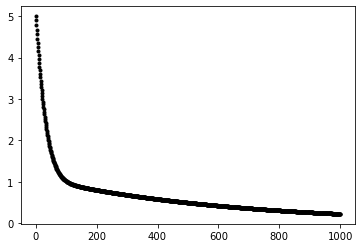

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def MSE_GD(x, y, theta, t, prec=10**-4, iter_max=10**3, backtrack=False, eta=0.6):
    grad_MSE = lambda _theta: (2/len(x))*x.T.dot(x.dot(_theta)-y) 
    i = 0
    err = [1]
    err_benchmark = [5]
    theta_benchmark = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    print("compare to "+str(theta_benchmark))
    while err[i]>prec or i<iter_max:
        theta_prev = theta
        if backtrack:
            t = backtrack(f_MSE, grad_MSE, x, eta)
        theta -= t*grad_MSE(theta)
        err.append(np.linalg.norm(theta_prev-theta))
        err_benchmark.append(np.linalg.norm(theta_benchmark-theta))
        i += 1
    return theta, err, err_benchmark

l = 100
x = np.random.rand(l, 1)
y = 4+3*x+np.random.randn(l, 1)
x = np.c_[np.ones((l, 1)), x]
theta_opt, err, err_bm = MSE_GD(x, y, np.zeros([2,1]), .01)
print("GD optimal theta "+str(theta_opt))
plt.figure()
plt.plot(err_bm, 'k.')

### Convergence

**Thm** Let $f$ be convex and differentiable and let its gradient be L-Lipschitz continuous. Let the fixed step size be $t\leq  1/L$. Then, after $k$ iterations, GD will yield a solution $x_k$ such that
$$
f(x_k)-f(x_*)\leq \frac{\|x_0-x_*\|_2^2}{2tk}
$$
where $x_*$ is the true minimizer.

**Cor** GD with fixed step size converges with rate $\mathcal O(k^{-1})$

The proof is fairly long though not too involved. Here are some important steps:


$f$ is L-smooth $\implies$ $\|f(x)-f(y)\|_2\leq L\|x-y\|_2$. Note the Taylor expansion:
$$
f(y)=f(x)+\langle y-x, \nabla f(x)\rangle+\langle y-x, \text{Hess}_y(y-x) \rangle+...
$$
The maximum eigenvalue of the Hessian is upper bounded by $L$. Then, the error is bounded by $\|y-x\|_2^2 L/2$ at this order in the expansion. Hence,
$$
f(y)\leq f(x)+\nabla f(x)^T(y-x)+\frac{L}{2}\|y-x\|_2^2.
$$
In the context of GD $y=x-t\nabla f(x)$, so:
$$
f(y)\leq f(x)-(1-Lt/2)t\|\nabla f(x)\|_2^2
$$
after some algebra. We asserted that $t\leq L^{-1}$ which simplifies the expression above to
$$
f(y)-f(x)\leq -\frac{t}{2}\|\nabla f(x)\|_2^2
$$
which is less than $0$ for finite gradients. Thus, $f$ is bound to decrease with each iteration until it hits $f(x_*)$. This proves that GD always converges if $t$ is chosen to be small enough.

f minimized at x=0.0583 after 288 iterations


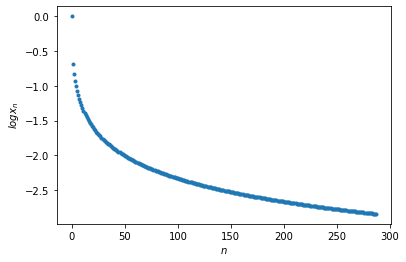

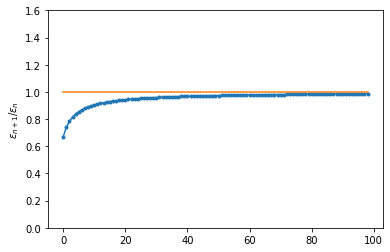

In [86]:
import numpy as np
import matplotlib.pyplot as plt
df = lambda x: 4*x**3
i = 0
err = [None]
x = 1
t = 1./8
x_vec = []
while i==0 or err[i]>10**-4:
    x_prev = x
    x_vec.append(x)
    x -= t*df(x) 
    err.append(abs(x_prev-x))
    i += 1
err = np.asarray(err)
err = err[err != np.array(None)]
err_shift = np.roll(err, 1)
rho  = err_shift[1:-1]/err[1:-1]
print("f minimized at x="+str(round(x,4))+" after "+str(i)+" iterations")
plt.figure()
plt.plot(np.log((x_vec)), '.')
plt.xlabel(r"$n$")
plt.ylabel(r"$log x_n$")
plt.savefig("logxn.png")
plt.figure()
plt.plot(rho[1:100]**-1, '.-')
plt.plot(np.ones(99))
plt.ylim((0,1.6))
plt.ylabel(r"$\varepsilon_{n+1}/\varepsilon_{n}$")
plt.savefig("error_ratio.png")

## Backtracking Armijo line search to determine step sizes

Convergence may be improved by adaptively determining the step size.

> Choose an $\eta\in(0,1)$ and during each iteration starting with $\alpha_0=1$ and while
$$
f(x-\text{sgn}(\nabla f(x))\alpha_j)<f(x)-\alpha_jc\| \nabla f(x)\|
$$
for some $c\in (0,1)$ updating the step sizes according to $\alpha_j=\eta\alpha_{j-1}$. For dimensions greater than 1, one replaces $\text{sgn}\nabla f$ with a general $\hat p$ (which can be chosen as the normalized negative gradient) that indicates the descent direction. 

Clearly, the line search introduces extra computation cost at each iteration but offers faster convergence because a more or less *correct* step size is used at each step. A step of $\alpha_k$ at GD iteration $k$ is optimal if it is the
$$
\text{argmin}_{\alpha>0} f(x-\alpha \nabla f).
$$
We approximate this by introducing two hyper parameters and ensuring the chosen step size achieves an acceptable decrease in $f$ in the search direction while ensuring the step size doesn't get too large or too small.



Let us implement it for a simple minimization problem:
$$
\text{argmin}_{x\in \mathbb R}\left\{ x^2-2x+5\right\}
$$

In [262]:
import numpy as np
import matplotlib.pyplot as plt

def backtrack(f, df, x, eta=0.1, c=0.3):
    i = 0
    alpha = [1]
    grad = df(x)
    p = -grad
    t = -c*p@grad
    while f(x)-f(x+alpha[i]*p) < alpha[i]*t:
        alpha.append(eta*alpha[i])
        i += 1
    return alpha[-1]

def gd(f, df, x, t=0.2, tol=10**-4, store_intermediate=False):
    err = [1000]
    x_vec = []
    i = 0
    while err[i]> tol:
        x_prev = x
        if store_intermediate:
            x_vec.append(x)
        x = x-t*df(x)
        t = backtrack(f, df, x)
        i += 1
        err.append(np.linalg.norm(df(x)))
    return x, err

15.273506473629428
12.218805178903542
9.775044143122834
7.820035314498266
6.256028251598613
5.004822601278891
4.003858081023112
3.2030864648184894
2.5624691718547914
2.0499753374838328
1.6399802699870663
1.3119842159896526
1.049587372791722
0.8396698982333778
0.6717359185867022
0.5373887348693615
0.4299109878954891
0.343928790316391
0.2751430322531127
0.22011442580249016
0.17609154064199212
0.1408732325135937
0.11269858601087483
0.09015886880869961
0.0721270950469597
0.05770167603756788
0.04616134083005405
0.036929072664043494
0.029543258131234543
0.023634606504987634
0.018907685203990107
0.015126148163192212
0.012100918530553518
0.009680734824442814
0.0077445878595541265
0.006195670287643175
0.004956536230114289
0.003965228984091557
0.00317218318727312
0.002537746549818496
0.0020301972398550482
0.0016241577918839128
0.0012993262335072558
0.0010394609868056791
0.0008315687894445432
0.0006652550315553833
0.0005322040252444323
0.00042576322019579704
0.0003406105761568889
0.00027248846092

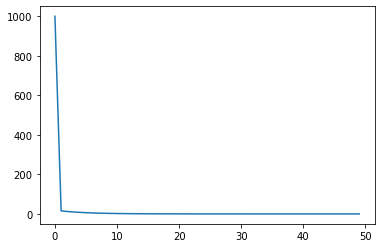

In [256]:
g = lambda x : x.T@(x-2)
dg =lambda x : 2*x-2
x_res, err = gd(g, dg, np.array([10,10]))
print(x_res)
plt.plot(err[:50])

In [269]:
from scipy.stats import norm, bernoulli
d = 5
n = 2000
beta_ = np.sqrt(1/d)*np.ones(d)
print(beta_)
x = norm.rvs(size=[n,d])
y = bernoulli.rvs(p=1/(1+np.exp(-x@beta_)),size=n)
len(y)

[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


2000

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))    
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        self.beta = np.zeros(X.shape[1])
        def f(beta_):
            return self.__loss( self.__sigmoid(X@beta_), y)
        
        def df(beta_):
            return X.T@(self.__sigmoid(X@beta_)-y)/len(y)#-np.sum(y-self.__sigmoid(X@beta_)*x.T,axis=1)/n
        print(f(self.beta))
        # def df(x):
        #     return x*(self.__sigmoid(X@x)-y) / y.shape[0]
        print(df(beta))
        self.beta, self.error = gd(f, df, np.zeros(d))
#         for i in range(self.num_iter):
#             z = X@self.beta
#             h = self.__sigmoid(z)
#             gradient = np.dot(X.T, (h - y)) / y.size
#             self.beta -= self.lr * gradient
            
#             if(self.verbose == True and i % 10000 == 0):
#                 z = np.dot(X, self.theta)
#                 h = self.__sigmoid(z)
#                 print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [273]:
model = LogisticRegression(fit_intercept=False)
model.fit(x, y)

0.6931471805599454
[0.08028148 0.08203066 0.10911857 0.08045426 0.07832292]


C:\Users\Bora\AppData\Local\Temp/ipykernel_5692/1903406848.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [274]:
model.beta

array([0.50827562, 0.45625243, 0.37112677, 0.44228692, 0.5007935 ])

In [83]:
np.linalg.norm([1,2])

2.23606797749979

In [30]:
i = 0
err = [1]
x = -1.1
t = 0.33
x_vec = t_vec = []
while err[i]>10**-4:
    x_prev = x
    x_vec.append(x)
    x -= t*df(x) 
    t = backtrack(f, df, x)
    err.append(abs(x_prev-x))
    i += 1
print("f minimized at x="+str(round(x,4))+" after "+str(i)+" iterations using adaptive GD")
plt.figure()
plt.plot(np.log(err[1:i+10]), 'k.')
plt.ylabel("log error")
plt.figure()
x_vec = np.asarray(x_vec)
x_ = np.linspace(-1.1,2,len(x_vec))
plt.plot(x_vec, x_vec**2-2*x_vec+5,'k.-')
plt.plot(x_, x_**2-2*x_+5)

array([0.98203696, 2.08523724, 0.79201997, 0.14705498, 0.06245237])

## Exact line search

Not as useful as backtracking, but we could of course compute the optimal step size at each iteration exactly.

## Stochastic gradient descent

Suppose we have access to a noisy version of $f:\mathbb{R}^n\to \mathbb R$, $g(x,Z)$, $Z\sim p$ such that 
$$
\mathbb E_p[g(x, Z)]=f(x).
$$
Note that 
$$
\mathbb E_p[\nabla_x g(x, Z)]=f'(x)
$$
by linearity of both operations. The error metric will be the MSE: $\varepsilon = \mathbb E[f(x)]-f(x_*)$ with the assumption that $\exists!\hspace{1mm} \text{argmin}_{x\in \mathbb R^n}f(x)$.


Let $\{a_n\}$ be a positive *deterministic* sequence with the convergence properties 
$$
\sum_n a_n\to \infty
$$
$$
\sum_n a_n^2<\infty
$$

Then we have the algorithm

- Initialize $X_1$
- For $n=1,2,...$ do until convergence:
  - Draw $Z_n$ from $p$
  - Update
$
X_{n+1}=X_n -a_n\nabla g(x_n, Z_n)
$


As an elementary example, consider $f(x)=x^2/2$ with $g(x,Z) = \frac{1}{2}(x+Z)^2-\frac{1}{2}$, $\mathbb E[Z]=0$, $\text{var} (Z)=1$

0.001432026198263841


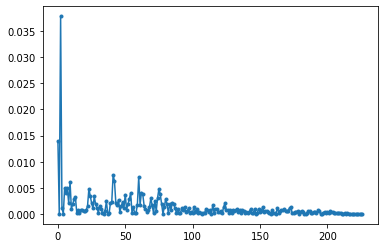

In [351]:
from scipy.stats import norm
a = lambda n: n**-1
dg = lambda x,z: x+z
f = lambda x: x*x/2
df = lambda x: x
x = 1
x_vec = []
err_vec = []
err = None
i = 1
while err is None or abs(err)>10**-8:
    z = norm.rvs()
    x_prev = x
    x_vec.append(x)
    err = np.abs(np.sum(norm.rvs(size=100)*f(x))/100)
    #err = norm.expect(lambda _: f(x))
    err_vec.append(err)
    x = x-a(i)*dg(x, z)
    i += 1
print(x)
plt.plot(err_vec, '.-')

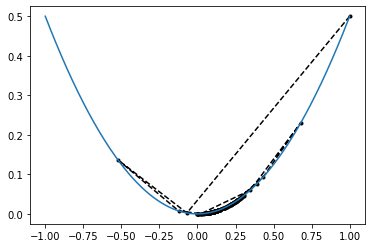

In [352]:
x_vec = np.asarray(x_vec)
x_ = np.linspace(-1, 1,len(x_vec))
plt.plot(x_vec, x_vec**2/2,'k.--')
plt.plot(x_, x_**2/2)

### Averaged SGD